Test the function for training guassian process regression

In [1]:
# Load libraries and modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from modelval import pairptl, network, trainer, dataset, perform_eval
from modelval.ArbDataGen import arb_w_gen
from modelval.spk_visu import spk_see, raster
from sklearn.utils import check_random_state
from modelval import gp_regressor
from sklearn.model_selection import KFold
import pdb

import warnings

warnings.filterwarnings('ignore')

% matplotlib inline
% load_ext autoreload
% autoreload 2

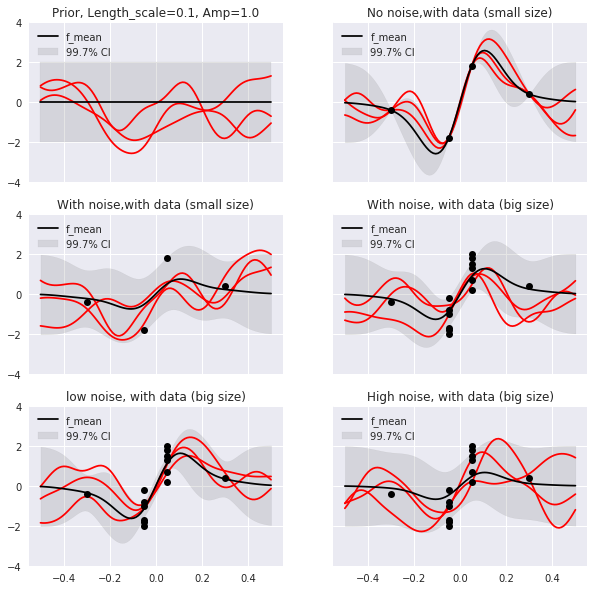

In [2]:
# Generate pior with basic radial basis covariance function
fig, ax = plt.subplots(3,2, sharex=True, sharey=True)
fig.set_figheight(10)
fig.set_figwidth(10)


x_test = np.linspace(-0.5,0.5,100).reshape(-1,1)
prior_rg = gp_regressor.GP_regressor(x_test=x_test, length_scale=0.1, amp_kernel=1)
f,v_f,lg = prior_rg.fit()

std = np.sqrt(v_f.transpose().diagonal()).reshape(-1,1)

# Sample from the distribution
y_samp = prior_rg.sample(n_samples=3, seed=10)
ax[0,0].plot(x_test,y_samp, 'r')
ax[0,0].set_title('Prior, Length_scale=%0.1f, Amp=%0.1f' %(0.1,1))

ax[0,0].plot(x_test, f, 'k', label='f_mean')
ax[0,0].fill_between(np.squeeze(x_test), np.squeeze(f-2*std), np.squeeze(f+2*std), alpha=0.2, color='gray', label='99.7% CI')
ax[0,0].legend(loc='upper left')

## --------------------------------------------------------
# Generate pior with basic radial basis covariance function
x = np.array([-0.3,-0.05,0.05,0.3]).reshape(-1,1)
y = np.array([-0.4,-1.8,1.8,0.4]).reshape(-1,1)

x_test = np.linspace(-0.5,0.5,100).reshape(-1,1)
prior_rg = gp_regressor.GP_regressor(x=x, y=y, x_test=x_test, length_scale=0.1, amp_kernel=1)
f,v_f,lg = prior_rg.fit()

std = np.sqrt(v_f.transpose().diagonal()).reshape(-1,1)

# Sample from the distribution
y_samp = prior_rg.sample(n_samples=3, seed=10)
ax[0,1].plot(x_test,y_samp, 'r')
ax[0,1].set_title('No noise,with data (small size)')

ax[0,1].plot(x_test, f, 'k', label='f_mean')
ax[0,1].plot(x,y,"ko")
ax[0,1].fill_between(np.squeeze(x_test), np.squeeze(f-2*std), np.squeeze(f+2*std), alpha=0.2, color='gray', label='99.7% CI')
ax[0,1].legend(loc='upper left')

## --------------------------------------------------------
# Generate pior with basic radial basis covariance function
x = np.array([-0.3,-0.05,0.05,0.3]).reshape(-1,1)
y = np.array([-0.4,-1.8,1.8,0.4]).reshape(-1,1)

x_test = np.linspace(-0.5,0.5,100).reshape(-1,1)
prior_rg = gp_regressor.GP_regressor(x=x, y=y, x_test=x_test, length_scale=0.1, amp_kernel=1, sigma_noise=1)
f,v_f,lg = prior_rg.fit()

std = np.sqrt(v_f.transpose().diagonal()).reshape(-1,1)

# Sample from the distribution
y_samp = prior_rg.sample(n_samples=3, seed=10)
ax[1,0].plot(x_test,y_samp, 'r')
ax[1,0].set_title('With noise,with data (small size)')

ax[1,0].plot(x_test, f, 'k', label='f_mean')
ax[1,0].plot(x,y,"ko")
ax[1,0].fill_between(np.squeeze(x_test), np.squeeze(f-2*std), np.squeeze(f+2*std), alpha=0.2, color='gray', label='99.7% CI')
ax[1,0].legend(loc='upper left')

## --------------------------------------------------------
# Generate pior with basic radial basis covariance function
x = np.array([-0.3,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.3]).reshape(-1,1)
y = np.array([-0.4,-1.8,-1.7,-1,-2,-0.8,-0.2, 0.2,0.7,1.3,1.5,1.8,2.0,0.4]).reshape(-1,1)

x_test = np.linspace(-0.5,0.5,100).reshape(-1,1)
prior_rg = gp_regressor.GP_regressor(x=x, y=y, x_test=x_test, length_scale=0.1, amp_kernel=1, sigma_noise=1)
f,v_f,lg = prior_rg.fit()

std = np.sqrt(v_f.transpose().diagonal()).reshape(-1,1)

# Sample from the distribution
y_samp = prior_rg.sample(n_samples=3, seed=10)
ax[1,1].plot(x_test,y_samp, 'r')
ax[1,1].set_title('With noise, with data (big size)')

ax[1,1].plot(x_test, f, 'k', label='f_mean')
ax[1,1].plot(x,y,"ko")
ax[1,1].fill_between(np.squeeze(x_test), np.squeeze(f-2*std), np.squeeze(f+2*std), alpha=0.2, color='gray', label='99.7% CI')
ax[1,1].legend(loc='upper left')

## --------------------------------------------------------
# Generate pior with basic radial basis covariance function
x = np.array([-0.3,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.3]).reshape(-1,1)
y = np.array([-0.4,-1.8,-1.7,-1,-2,-0.8,-0.2, 0.2,0.7,1.3,1.5,1.8,2.0,0.4]).reshape(-1,1)

x_test = np.linspace(-0.5,0.5,100).reshape(-1,1)
prior_rg = gp_regressor.GP_regressor(x=x, y=y, x_test=x_test, sigma_noise=0.5,length_scale=0.1, amp_kernel=1, )
f,v_f,lg = prior_rg.fit()

std = np.sqrt(v_f.transpose().diagonal()).reshape(-1,1)

# Sample from the distribution
y_samp = prior_rg.sample(n_samples=3, seed=2)
ax[2,0].plot(x_test,y_samp, 'r')
ax[2,0].set_title('low noise, with data (big size)')

ax[2,0].plot(x_test, f, 'k', label='f_mean')
ax[2,0].plot(x,y,"ko")
ax[2,0].fill_between(np.squeeze(x_test), np.squeeze(f-2*std), np.squeeze(f+2*std), alpha=0.2, color='gray', label='99.7% CI')
ax[2,0].legend(loc='upper left')

## --------------------------------------------------------
# Generate pior with basic radial basis covariance function
x = np.array([-0.3,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.3]).reshape(-1,1)
y = np.array([-0.4,-1.8,-1.7,-1,-2,-0.8,-0.2, 0.2,0.7,1.3,1.5,1.8,2.0,0.4]).reshape(-1,1)

x_test = np.linspace(-0.5,0.5,100).reshape(-1,1)
prior_rg = gp_regressor.GP_regressor(x=x, y=y, x_test=x_test, sigma_noise=2,length_scale=0.1, amp_kernel=1, )
f,v_f,lg = prior_rg.fit()

std = np.sqrt(v_f.transpose().diagonal()).reshape(-1,1)

# Sample from the distribution
y_samp = prior_rg.sample(n_samples=3, seed=2)
ax[2,1].plot(x_test,y_samp, 'r')
ax[2,1].set_title('High noise, with data (big size)')

ax[2,1].plot(x_test, f, 'k', label='f_mean')
ax[2,1].plot(x,y,"ko")
ax[2,1].fill_between(np.squeeze(x_test), np.squeeze(f-2*std), np.squeeze(f+2*std), alpha=0.2, color='gray', label='99.7% CI')
ax[2,1].legend(loc='upper left')

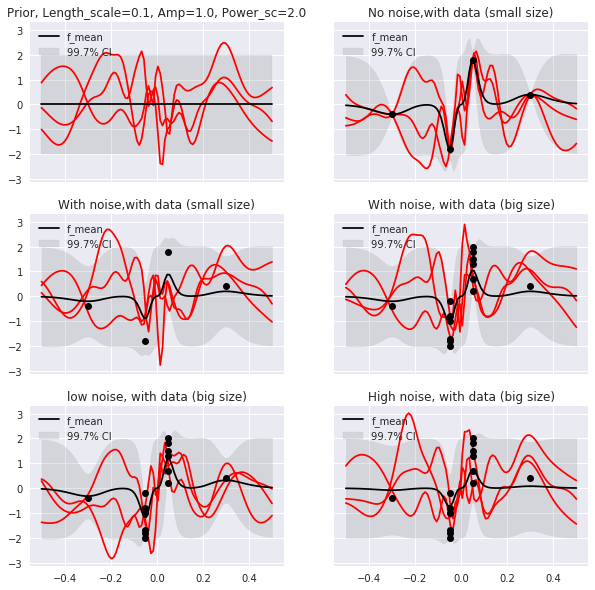

In [3]:
# Change the pior kernel to be non-stationary, through covariance 
fig, ax = plt.subplots(3,2, sharex=True, sharey=True)
params = {
    'amp_kernel': 1,
    'length_scale': 0.1,
    'power_sc': 1,
}

fig.set_figheight(10)
fig.set_figwidth(10)

x_test = np.linspace(-0.5,0.5,100).reshape(-1,1)
prior_rg = gp_regressor.GP_regressor(x_test=x_test, **params)
f,v_f,lg = prior_rg.fit()

std = np.sqrt(v_f.transpose().diagonal()).reshape(-1,1)

# Sample from the distribution
y_samp = prior_rg.sample(n_samples=3, seed=2)
ax[0,0].plot(x_test,y_samp, 'r')
ax[0,0].set_title('Prior, Length_scale=%0.1f, Amp=%0.1f, Power_sc=%0.1f' %(0.1,1,2))

ax[0,0].plot(x_test, f, 'k', label='f_mean')
ax[0,0].fill_between(np.squeeze(x_test), np.squeeze(f-2*std), np.squeeze(f+2*std), alpha=0.2, color='gray', label='99.7% CI')
ax[0,0].legend(loc='upper left')

## --------------------------------------------------------
# Generate pior with basic radial basis covariance function
x = np.array([-0.3,-0.05,0.05,0.3]).reshape(-1,1)
y = np.array([-0.4,-1.8,1.8,0.4]).reshape(-1,1)

x_test = np.linspace(-0.5,0.5,100).reshape(-1,1)
prior_rg = gp_regressor.GP_regressor(x=x, y=y, x_test=x_test, **params)
f,v_f,lg = prior_rg.fit()

std = np.sqrt(v_f.transpose().diagonal()).reshape(-1,1)

# Sample from the distribution
y_samp = prior_rg.sample(n_samples=3, seed=2)
ax[0,1].plot(x_test,y_samp, 'r')
ax[0,1].set_title('No noise,with data (small size)')

ax[0,1].plot(x_test, f, 'k', label='f_mean')
ax[0,1].plot(x,y,"ko")
ax[0,1].fill_between(np.squeeze(x_test), np.squeeze(f-2*std), np.squeeze(f+2*std), alpha=0.2, color='gray', label='99.7% CI')
ax[0,1].legend(loc='upper left')

## --------------------------------------------------------
# Generate pior with basic radial basis covariance function
x = np.array([-0.3,-0.05,0.05,0.3]).reshape(-1,1)
y = np.array([-0.4,-1.8,1.8,0.4]).reshape(-1,1)

x_test = np.linspace(-0.5,0.5,100).reshape(-1,1)
prior_rg = gp_regressor.GP_regressor(x=x, y=y, x_test=x_test, sigma_noise=1,**params)
f,v_f,lg = prior_rg.fit()

std = np.sqrt(v_f.transpose().diagonal()).reshape(-1,1)

# Sample from the distribution
y_samp = prior_rg.sample(n_samples=3, seed=2)
ax[1,0].plot(x_test,y_samp, 'r')
ax[1,0].set_title('With noise,with data (small size)')

ax[1,0].plot(x_test, f, 'k', label='f_mean')
ax[1,0].plot(x,y,"ko")
ax[1,0].fill_between(np.squeeze(x_test), np.squeeze(f-2*std), np.squeeze(f+2*std), alpha=0.2, color='gray', label='99.7% CI')
ax[1,0].legend(loc='upper left')

## --------------------------------------------------------
# Generate pior with basic radial basis covariance function
x = np.array([-0.3,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.3]).reshape(-1,1)
y = np.array([-0.4,-1.8,-1.7,-1,-2,-0.8,-0.2, 0.2,0.7,1.3,1.5,1.8,2.0,0.4]).reshape(-1,1)

x_test = np.linspace(-0.5,0.5,100).reshape(-1,1)
prior_rg = gp_regressor.GP_regressor(x=x, y=y, x_test=x_test, sigma_noise=1, **params)
f,v_f,lg = prior_rg.fit()

std = np.sqrt(v_f.transpose().diagonal()).reshape(-1,1)

# Sample from the distribution
y_samp = prior_rg.sample(n_samples=3, seed=2)
ax[1,1].plot(x_test,y_samp, 'r')
ax[1,1].set_title('With noise, with data (big size)')

ax[1,1].plot(x_test, f, 'k', label='f_mean')
ax[1,1].plot(x,y,"ko")
ax[1,1].fill_between(np.squeeze(x_test), np.squeeze(f-2*std), np.squeeze(f+2*std), alpha=0.2, color='gray', label='99.7% CI')
ax[1,1].legend(loc='upper left')

## --------------------------------------------------------
# Generate pior with basic radial basis covariance function
x = np.array([-0.3,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.3]).reshape(-1,1)
y = np.array([-0.4,-1.8,-1.7,-1,-2,-0.8,-0.2, 0.2,0.7,1.3,1.5,1.8,2.0,0.4]).reshape(-1,1)

x_test = np.linspace(-0.5,0.5,100).reshape(-1,1)
prior_rg = gp_regressor.GP_regressor(x=x, y=y, x_test=x_test, sigma_noise=0.5, **params)
f,v_f,lg = prior_rg.fit()

std = np.sqrt(v_f.transpose().diagonal()).reshape(-1,1)

# Sample from the distribution
y_samp = prior_rg.sample(n_samples=3, seed=2)
ax[2,0].plot(x_test,y_samp, 'r')
ax[2,0].set_title('low noise, with data (big size)')

ax[2,0].plot(x_test, f, 'k', label='f_mean')
ax[2,0].plot(x,y,"ko")
ax[2,0].fill_between(np.squeeze(x_test), np.squeeze(f-2*std), np.squeeze(f+2*std), alpha=0.2, color='gray', label='99.7% CI')
ax[2,0].legend(loc='upper left')

## --------------------------------------------------------
# Generate pior with basic radial basis covariance function
x = np.array([-0.3,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.3]).reshape(-1,1)
y = np.array([-0.4,-1.8,-1.7,-1,-2,-0.8,-0.2, 0.2,0.7,1.3,1.5,1.8,2.0,0.4]).reshape(-1,1)

x_test = np.linspace(-0.5,0.5,100).reshape(-1,1)
prior_rg = gp_regressor.GP_regressor(x=x, y=y, x_test=x_test, sigma_noise=2, **params)
f,v_f,lg = prior_rg.fit()

std = np.sqrt(v_f.transpose().diagonal()).reshape(-1,1)

# Sample from the distribution
y_samp = prior_rg.sample(n_samples=3, seed=2)
ax[2,1].plot(x_test,y_samp, 'r')
ax[2,1].set_title('High noise, with data (big size)')

ax[2,1].plot(x_test, f, 'k', label='f_mean')
ax[2,1].plot(x,y,"ko")
ax[2,1].fill_between(np.squeeze(x_test), np.squeeze(f-2*std), np.squeeze(f+2*std), alpha=0.2, color='gray', label='99.7% CI')
ax[2,1].legend(loc='upper left')

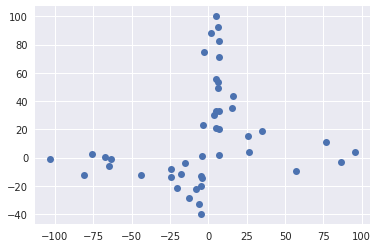

In [4]:
data = pd.read_csv('/src/Plasticity_Ker/data/kernel_training_data_auto.csv')
data1 = data[data['ptl_idx']==1]

plt.plot(data1['dt1'], data1['dw_mean'],'o')

In [5]:
# Generate data for STDP
std_stdp = data1[np.abs(data1['dt1'])>50]['dw_mean'].std()
data1_cp = data1.copy()
data1_cp['dw_mean'] = data1_cp['dw_mean']/std_stdp

data1_cp[np.abs(data1_cp['dt1'])>50]['dw_mean'].std()

1.0

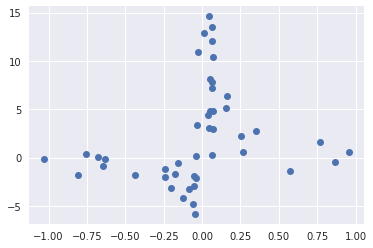

In [6]:
x = np.array(data1['dt1']).reshape(-1,1)/100
y = np.array(data1['dw_mean']).reshape(-1,1)/std_stdp
      
plt.plot(x, y,'o')

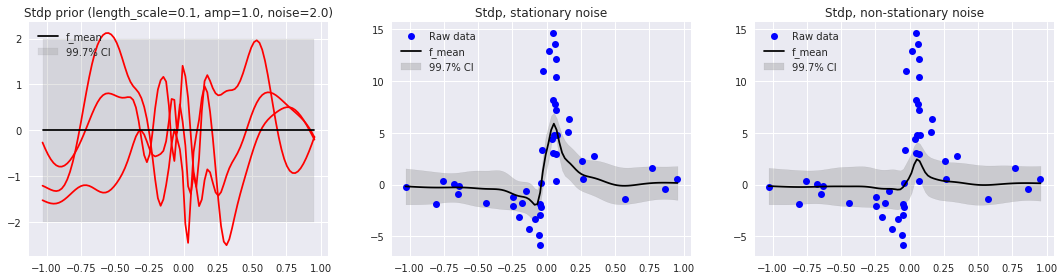

In [7]:
# Hand pick Amplitude

params_stdp  = {
    'length_scale': 0.1,
    'power_sc':1,
    'amp_kernel':1,
    'sigma_noise':2
}

fig, ax = plt.subplots(1,3,sharex=True, sharey=False)
fig.set_figwidth(15)
fig.set_figheight(4)

x_test = np.linspace(np.min(x),np.max(x),100).reshape(-1,1)
prior_rg = gp_regressor.GP_regressor(x_test=x_test,  **params_stdp)
f,v_f,lg = prior_rg.fit()

std = np.sqrt(v_f.transpose().diagonal()).reshape(-1,1)

# Sample from the distribution

y_samp = prior_rg.sample(n_samples=3, seed=2)
ax[0].plot(x_test,y_samp, 'r')
ax[0].set_title('Stdp prior (length_scale=%0.1f, amp=%0.1f, noise=%0.1f)'%(0.1,1,2))

ax[0].plot(x_test, f, 'k', label='f_mean')
ax[0].fill_between(np.squeeze(x_test), np.squeeze(f-2*std), np.squeeze(f+2*std), alpha=0.2, color='gray', label='99.7% CI')
ax[0].legend(loc='upper left')
## ------------------------------------------------
prior_rg = gp_regressor.GP_regressor(x=x, y=y, x_test=x_test,  **params_stdp)
f,v_f,lg = prior_rg.fit(y_bias=0)

std = np.sqrt(v_f.transpose().diagonal()).reshape(-1,1)

# Sample from the distribution
ax[1].plot(x,y,"bo", label='Raw data')

y_samp = prior_rg.sample(n_samples=3, seed=2)
#ax[1].plot(x_test,y_samp, 'r', alpha=0.5)
ax[1].set_title('Stdp, stationary noise')

ax[1].plot(x_test, f, 'k', label='f_mean')
ax[1].fill_between(np.squeeze(x_test), np.squeeze(f-2*std), np.squeeze(f+2*std), alpha=0.3, color='gray', label='99.7% CI')
ax[1].legend(loc='upper left')
## ------------------------------------------------
prior_rg = gp_regressor.GP_regressor(x=x, y=y, x_test=x_test,  noise_sc=1, **params_stdp)
f,v_f,lg = prior_rg.fit(y_bias=0)

std = np.sqrt(v_f.transpose().diagonal()).reshape(-1,1)

# Sample from the distribution
ax[2].plot(x,y,"bo", label='Raw data')

y_samp = prior_rg.sample(n_samples=3, seed=2)
#ax[1].plot(x_test,y_samp, 'r', alpha=0.5)
ax[2].set_title('Stdp, non-stationary noise')

ax[2].plot(x_test, f, 'k', label='f_mean')
ax[2].fill_between(np.squeeze(x_test), np.squeeze(f-2*std), np.squeeze(f+2*std), alpha=0.3, color='gray', label='99.7% CI')
ax[2].legend(loc='upper left')

plt.tight_layout()

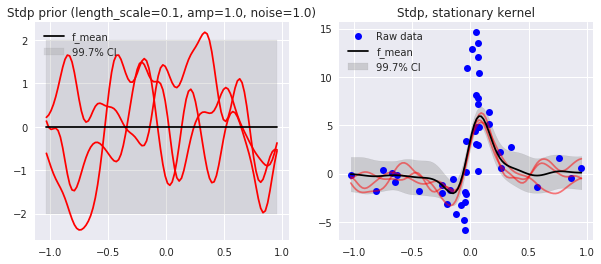

In [63]:
# Hand pick Amplitude

params_stdp  = {
    'length_scale': 0.1,
    'power_sc':0,
    'amp_kernel':1,
    'sigma_noise':2,
}

fig, ax = plt.subplots(1,2,sharex=True, sharey=False)
fig.set_figwidth(10)
fig.set_figheight(4)

x_test = np.linspace(np.min(x),np.max(x),100).reshape(-1,1)
prior_rg = gp_regressor.GP_regressor(x_test=x_test,  **params_stdp)
f,v_f,lg = prior_rg.fit()

std = np.sqrt(v_f.transpose().diagonal()).reshape(-1,1)

# Sample from the distribution

y_samp = prior_rg.sample(n_samples=3, seed=2)
ax[0].plot(x_test,y_samp, 'r')
ax[0].set_title('Stdp prior (length_scale=%0.1f, amp=%0.1f, noise=%0.1f)'%(0.1,1,1))

ax[0].plot(x_test, f, 'k', label='f_mean')
ax[0].fill_between(np.squeeze(x_test), np.squeeze(f-2*std), np.squeeze(f+2*std), alpha=0.2, color='gray', label='99.7% CI')
ax[0].legend(loc='upper left')
## ------------------------------------------------
prior_rg = gp_regressor.GP_regressor(x=x, y=y, x_test=x_test,  **params_stdp)
f,v_f,lg = prior_rg.fit(y_bias=0)

std = np.sqrt(v_f.transpose().diagonal()).reshape(-1,1)

# Sample from the distribution
ax[1].plot(x,y,"bo", label='Raw data')

y_samp = prior_rg.sample(n_samples=3, seed=2)
#ax[1].plot(x_test,y_samp, 'r', alpha=0.5)
ax[1].set_title('Stdp, stationary kernel')
ax[1].plot(x_test,y_samp, 'r', alpha=0.5)

ax[1].plot(x_test, f, 'k', label='f_mean')
ax[1].fill_between(np.squeeze(x_test), np.squeeze(f-2*std), np.squeeze(f+2*std), alpha=0.3, color='gray', label='99.7% CI')
ax[1].legend(loc='upper left')

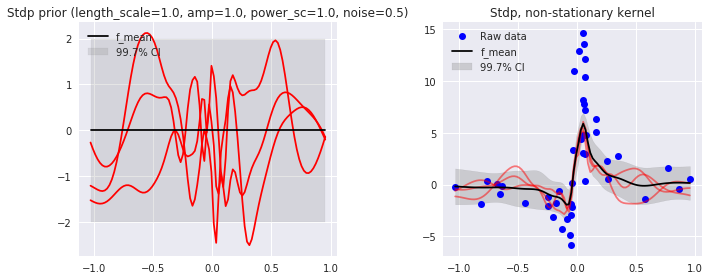

In [64]:
# Hand pick Amplitude

params_stdp  = {
    'length_scale': 0.1,
    'power_sc':1,
    'amp_kernel':1,
    'sigma_noise':2,
}


fig, ax = plt.subplots(1,2,sharex=True, sharey=False)
fig.set_figwidth(10)
fig.set_figheight(4)

x = np.array(data1['dt1']).reshape(-1,1)/100
y = np.array(data1['dw_mean']).reshape(-1,1)/std_stdp

x_test = np.linspace(np.min(x),np.max(x),100).reshape(-1,1)
prior_rg = gp_regressor.GP_regressor(x_test=x_test,  **params_stdp)
f,v_f,lg = prior_rg.fit()

std = np.sqrt(v_f.transpose().diagonal()).reshape(-1,1)

# Sample from the distribution

y_samp = prior_rg.sample(n_samples=3, seed=2)
ax[0].plot(x_test,y_samp, 'r')
ax[0].set_title('Stdp prior (length_scale=%0.1f, amp=%0.1f, power_sc=%0.1f, noise=%0.1f)'%(1,1,1,0.5))

ax[0].plot(x_test, f, 'k', label='f_mean')
ax[0].fill_between(np.squeeze(x_test), np.squeeze(f-2*std), np.squeeze(f+2*std), alpha=0.2, color='gray', label='99.7% CI')
ax[0].legend(loc='upper left')
## ------------------------------------------------
prior_rg = gp_regressor.GP_regressor(x=x, y=y, x_test=x_test,  **params_stdp)
f,v_f,lg = prior_rg.fit(y_bias=0)

std = np.sqrt(v_f.transpose().diagonal()).reshape(-1,1)

# Sample from the distribution
ax[1].plot(x,y,"bo", label='Raw data')

y_samp = prior_rg.sample(n_samples=3, seed=2)
ax[1].plot(x_test,y_samp, 'r', alpha=0.5)
ax[1].set_title('Stdp, non-stationary kernel')

ax[1].plot(x_test, f, 'k', label='f_mean')
ax[1].fill_between(np.squeeze(x_test), np.squeeze(f-2*std), np.squeeze(f+2*std), alpha=0.3, color='gray', label='99.7% CI')
ax[1].legend(loc='upper left')
plt.tight_layout()

In [42]:
# Check the mse with the hand picked parameter
from sklearn.model_selection import KFold

param_list  = {'amp_kernel': [1],
 'length_scale': [0.90000000000000002],
 'power_sc': [1.4000000000000001],
 'sigma_noise': [0.20000000000000001]}


x = np.array(data1['dt1']).reshape(-1,1)/100
y = np.array(data1['dw_mean']).reshape(-1,1)/std_stdp

# Convert to parameter grid
from sklearn.model_selection import ParameterGrid
param_grid = list(ParameterGrid(param_list))

kf = KFold(n_splits=10, shuffle=True, random_state=0)

mse = np.zeros(len(param_grid))
for i in range(len(param_grid)):
    k=0
    mse_tmp = np.ones(kf.get_n_splits()) * np.nan
    for train_index, test_index in kf.split(x):
        x_train = x[train_index, :].reshape(-1,1)
        y_train = y[train_index, :].reshape(-1,1)
        x_test = x[test_index, :].reshape(-1,1)
        y_test = y[test_index, :].reshape(-1,1)
        gp_rg=gp_regressor.GP_regressor(x_train, y_train, x_test, **param_grid[i])
        try:
            gp_rg.fit(y_bias=0)
        except:
            continue
        f, _, _ = gp_rg.fit(y_bias=0)
        mse_tmp[k] = np.nanmean(np.square(f - y_test))
        k+=1
    mse[i] = np.nanmean(mse_tmp)

In [53]:
# Hyperparameter search
# Create the parameter list
param_list={
    'length_scale': np.arange(0.1,2,0.1),
    'power_sc':np.arange(0.2,2,0.2),
    'amp_kernel':[1],
    'sigma_noise':np.arange(1.0,2.0,0.1)
}

x = np.array(data1['dt1']).reshape(-1,1)/100
y = np.array(data1['dw_mean']).reshape(-1,1)/std_stdp
x_test = np.linspace(np.min(x),np.max(x),100).reshape(-1,1)

# Convert to parameter grid
from sklearn.model_selection import ParameterGrid
param_grid = list(ParameterGrid(param_list))

kf = KFold(n_splits=10, shuffle=True, random_state=0)
mse = np.ones(len(param_grid)) * np.inf

# Create table to store the parameter and mse
hyper_search = pd.DataFrame([], columns=param_list.keys())

for i in range(len(param_grid)):
    k = 0
    mse_tmp = np.ones(kf.get_n_splits(x)) * np.nan
    hyper_search = hyper_search.append(param_grid[i], ignore_index=True)
    for train_index, test_index in kf.split(x):
        train_x = x[train_index, :].reshape(-1,1)
        train_y = y[train_index, :].reshape(-1,1)
        test_x = x[test_index, :].reshape(-1,1)
        test_y = y[test_index, :].reshape(-1,1)
        gp_rg_all =gp_regressor.GP_regressor(x, y, x_test, **param_grid[i])
        gp_rg_cv=gp_regressor.GP_regressor(train_x, train_y, test_x, **param_grid[i])
        try:
            gp_rg_all.fit(y_bias=0)
            gp_rg_cv.fit(y_bias=0)
        except:
            continue
        f, _, _ = gp_rg_cv.fit(y_bias=0)
        mse_tmp[k] = np.nanmean(np.square(f - test_y))
        k += 1
    mse[i] = np.sum(mse_tmp)
    
hyper_search['mse'] = mse

In [54]:
hyper_search.iloc[np.argmin(hyper_search['mse'])]

sigma_noise       1.000000
length_scale      0.100000
amp_kernel        1.000000
power_sc          0.200000
mse             125.771955
Name: 0, dtype: float64

In [55]:
# Choose the parameter with minimum mse
param_best = param_grid[np.where(mse == np.nanmin(mse))[0][0]]
param_best
# param_best = {'amp_kernel': 1,
#  'length_scale': 0.10000000000000001,
#  'power_sc': 0.20000000000000001,
#  'sigma_noise': 1.0}

{'amp_kernel': 1,
 'length_scale': 0.10000000000000001,
 'power_sc': 0.20000000000000001,
 'sigma_noise': 1.0}

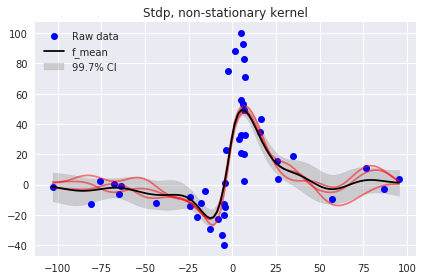

In [65]:
x = np.array(data1['dt1']).reshape(-1,1)/100
y = np.array(data1['dw_mean']).reshape(-1,1)/std_stdp

x_test = np.linspace(np.min(x),np.max(x),100).reshape(-1,1)

prior_rg = gp_regressor.GP_regressor(x=x, y=y, x_test=x_test,  **param_best)
f,v_f,lg = prior_rg.fit(y_bias=0)

std = np.sqrt(v_f.transpose().diagonal()).reshape(-1,1)

plt.plot(x*100,y*std_stdp,"bo", label='Raw data')

y_samp = prior_rg.sample(n_samples=3, seed=2)
plt.plot(x_test*100,y_samp*std_stdp, 'r', alpha=0.5)
plt.title('Stdp, non-stationary kernel')

plt.plot(x_test*100, f*std_stdp, 'k', label='f_mean')
plt.fill_between(np.squeeze(x_test*100), np.squeeze(f-2*std)*std_stdp, np.squeeze(f+2*std)*std_stdp, alpha=0.3, color='gray', label='99.7% CI')
plt.legend(loc='upper left')
plt.tight_layout()

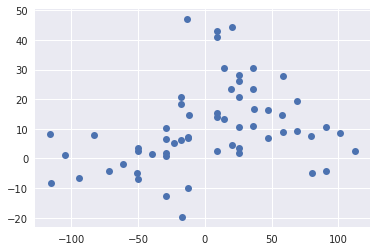

In [66]:
# Generate data for Quadruplet protocol
data3 = data[data['ptl_idx']==3]
plt.plot(data3['dt2'], data3['dw_mean'],'o', label='Raw_data_train')

In [67]:
std_quad = data3[(data3['dt2']<-50)]['dw_mean'].std()

x = np.array(data3['dt2']).reshape(-1,1)/100
y = np.array(data3['dw_mean']).reshape(-1,1)/std_quad

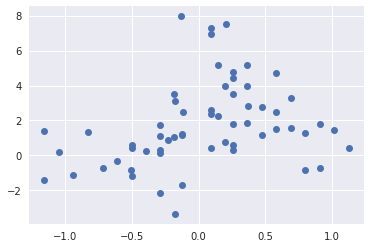

In [68]:
plt.plot(x,y,'o')

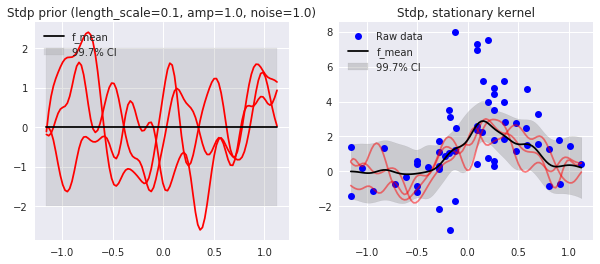

In [69]:
# Hand pick Amplitude

params_quad  = {
    'length_scale': 0.1,
    'power_sc':0,
    'amp_kernel':1,
    'sigma_noise':2,
}

fig, ax = plt.subplots(1,2,sharex=True, sharey=False)
fig.set_figwidth(10)
fig.set_figheight(4)

x_test = np.linspace(np.min(x),np.max(x),100).reshape(-1,1)
prior_rg = gp_regressor.GP_regressor(x_test=x_test,  **params_quad)
f,v_f,lg = prior_rg.fit()

std = np.sqrt(v_f.transpose().diagonal()).reshape(-1,1)

# Sample from the distribution

y_samp = prior_rg.sample(n_samples=3, seed=2)
ax[0].plot(x_test,y_samp, 'r')
ax[0].set_title('Stdp prior (length_scale=%0.1f, amp=%0.1f, noise=%0.1f)'%(0.1,1,1))

ax[0].plot(x_test, f, 'k', label='f_mean')
ax[0].fill_between(np.squeeze(x_test), np.squeeze(f-2*std), np.squeeze(f+2*std), alpha=0.2, color='gray', label='99.7% CI')
ax[0].legend(loc='upper left')
## ------------------------------------------------
prior_rg = gp_regressor.GP_regressor(x=x, y=y, x_test=x_test,  **params_quad)
f,v_f,lg = prior_rg.fit(y_bias=0)

std = np.sqrt(v_f.transpose().diagonal()).reshape(-1,1)

# Sample from the distribution
ax[1].plot(x,y,"bo", label='Raw data')

y_samp = prior_rg.sample(n_samples=3, seed=2)
#ax[1].plot(x_test,y_samp, 'r', alpha=0.5)
ax[1].set_title('Stdp, stationary kernel')
ax[1].plot(x_test,y_samp, 'r', alpha=0.5)

ax[1].plot(x_test, f, 'k', label='f_mean')
ax[1].fill_between(np.squeeze(x_test), np.squeeze(f-2*std), np.squeeze(f+2*std), alpha=0.3, color='gray', label='99.7% CI')
ax[1].legend(loc='upper left')

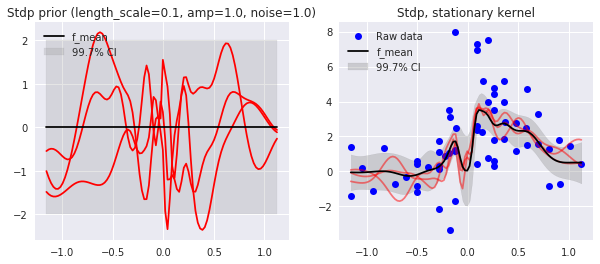

In [70]:
# Hand pick Amplitude

params_quad  = {
    'length_scale': 0.1,
    'power_sc':1,
    'amp_kernel':1,
    'sigma_noise':1
}

fig, ax = plt.subplots(1,2,sharex=True, sharey=False)
fig.set_figwidth(10)
fig.set_figheight(4)

x_test = np.linspace(np.min(x),np.max(x),100).reshape(-1,1)
prior_rg = gp_regressor.GP_regressor(x_test=x_test,  **params_quad)
f,v_f,lg = prior_rg.fit()

std = np.sqrt(v_f.transpose().diagonal()).reshape(-1,1)

# Sample from the distribution

y_samp = prior_rg.sample(n_samples=3, seed=2)
ax[0].plot(x_test,y_samp, 'r')
ax[0].set_title('Stdp prior (length_scale=%0.1f, amp=%0.1f, noise=%0.1f)'%(0.1,1,1))

ax[0].plot(x_test, f, 'k', label='f_mean')
ax[0].fill_between(np.squeeze(x_test), np.squeeze(f-2*std), np.squeeze(f+2*std), alpha=0.2, color='gray', label='99.7% CI')
ax[0].legend(loc='upper left')
## ------------------------------------------------
prior_rg = gp_regressor.GP_regressor(x=x, y=y, x_test=x_test,  **params_quad)
f,v_f,lg = prior_rg.fit(y_bias=0)

std = np.sqrt(v_f.transpose().diagonal()).reshape(-1,1)

# Sample from the distribution
ax[1].plot(x,y,"bo", label='Raw data')

y_samp = prior_rg.sample(n_samples=3, seed=2)
#ax[1].plot(x_test,y_samp, 'r', alpha=0.5)
ax[1].set_title('Stdp, stationary kernel')
ax[1].plot(x_test,y_samp, 'r', alpha=0.5)

ax[1].plot(x_test, f, 'k', label='f_mean')
ax[1].fill_between(np.squeeze(x_test), np.squeeze(f-2*std), np.squeeze(f+2*std), alpha=0.3, color='gray', label='99.7% CI')
ax[1].legend(loc='upper left')

In [78]:
# Hyperparameter search
# Create the parameter list
param_list={
    'length_scale': np.arange(0.05,1,0.05),
    'power_sc':np.arange(0.0,1,0.1),
    'amp_kernel':[1],
    'sigma_noise':np.arange(1.0,2.0,0.1)
}

x = np.array(data3['dt2']).reshape(-1,1)/100
y = np.array(data3['dw_mean']).reshape(-1,1)/std_quad
x_test = np.linspace(np.min(x),np.max(x),100).reshape(-1,1)

# Convert to parameter grid
from sklearn.model_selection import ParameterGrid
param_grid = list(ParameterGrid(param_list))

kf = KFold(n_splits=10, shuffle=True, random_state=0)
mse = np.ones(len(param_grid)) * np.inf

# Create table to store the parameter and mse
hyper_search = pd.DataFrame([], columns=param_list.keys())

for i in range(len(param_grid)):
    k = 0
    mse_tmp = np.ones(kf.get_n_splits(x)) * np.nan
    hyper_search = hyper_search.append(param_grid[i], ignore_index=True)
    for train_index, test_index in kf.split(x):
        train_x = x[train_index, :].reshape(-1,1)
        train_y = y[train_index, :].reshape(-1,1)
        test_x = x[test_index, :].reshape(-1,1)
        test_y = y[test_index, :].reshape(-1,1)
        gp_rg_all =gp_regressor.GP_regressor(x, y, x_test, **param_grid[i])
        gp_rg_cv=gp_regressor.GP_regressor(train_x, train_y, test_x, **param_grid[i])
        try:
            gp_rg_all.fit(y_bias=0)
            gp_rg_cv.fit(y_bias=0)
        except:
            continue
        f, _, _ = gp_rg_cv.fit(y_bias=0)
        mse_tmp[k] = np.nanmean(np.square(f - test_y))
        k += 1
    mse[i] = np.sum(mse_tmp)
    
hyper_search['mse'] = mse

In [79]:
# Choose the parameter with minimum mse
param_best = param_grid[np.where(mse == np.nanmin(mse))[0][0]]
# param_best = 
# {'amp_kernel': 1,
#  'length_scale': 0.45000000000000001,
#  'power_sc': 0.40000000000000002,
#  'sigma_noise': 1.2000000000000002}

{'amp_kernel': 1,
 'length_scale': 0.45000000000000001,
 'power_sc': 0.40000000000000002,
 'sigma_noise': 1.2000000000000002}

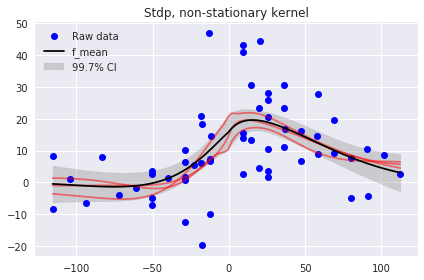

In [80]:
x = np.array(data3['dt2']).reshape(-1,1)/100
y = np.array(data3['dw_mean']).reshape(-1,1)/std_quad
x_test = np.linspace(np.min(x),np.max(x),100).reshape(-1,1)

prior_rg = gp_regressor.GP_regressor(x=x, y=y, x_test=x_test,  **param_best)
f,v_f,lg = prior_rg.fit(y_bias=0)

std = np.sqrt(v_f.transpose().diagonal()).reshape(-1,1)

plt.plot(x*100,y*std_quad,"bo", label='Raw data')

y_samp = prior_rg.sample(n_samples=3, seed=2)
plt.plot(x_test*100,y_samp*std_quad, 'r', alpha=0.5)
plt.title('Stdp, non-stationary kernel')

plt.plot(x_test*100, f*std_quad, 'k', label='f_mean')
plt.fill_between(np.squeeze(x_test*100), np.squeeze(f-2*std)*std_quad, np.squeeze(f+2*std)*std_quad, alpha=0.3, color='gray', label='99.7% CI')
plt.legend(loc='upper left')
plt.tight_layout()

In [ ]:
x_r = data3[data3['dt2']>0]['dt2'].reshape(-1,1)
y_r = data3[data3['dt2']>0]['dw_mean'].reshape(-1,1)
x_test_r = np.linspace(np.min(x_r),np.max(x_r),120).reshape(-1,1)
y_r = y_r/data3[np.abs(data3['dt2'])>100]['dw_mean'].std()

x_l = data3[data3['dt2']<0]['dt2'].reshape(-1,1)
y_l = data3[data3['dt2']<0]['dw_mean'].reshape(-1,1)
x_test_l = np.linspace(np.min(x_l),np.max(x_l),120).reshape(-1,1)
y_l = y_l/data3[np.abs(data3['dt2'])>100]['dw_mean'].std()

#best_params = {'sigma_kernel':1,'bias':5, 'sigma_obs':1, 'if_stat_kernel':False}

gp_rg = gp_regressor.GP_regressor(x_r, y_r, x_test_r, **best_params)
f, v_f_r, lp = gp_rg.fit()
f = f * data3[np.abs(data3['dt2'])>100]['dw_mean'].std()
std = np.sqrt(v_f_r.transpose().diagonal()).reshape(-1,1)* data3[np.abs(data3['dt2'])>100]['dw_mean'].std()
plt.plot(x_r, data3[data3['dt2']>0]['dw_mean'],'o', color='steelblue', label='Raw_data_train')
plt_range1 = np.arange(0,112,1)

plt.plot(x_test_r, f,'k')
plt.fill_between(np.squeeze(x_test_r), np.squeeze(f-1.96*std), np.squeeze(f+1.96*std), alpha=0.5, color='deeppink')


gp_rg = gp_regressor.GP_regressor(x_l, y_l, x_test_l, **best_params)
f, v_f_l, lp = gp_rg.fit()
f = f * data3[np.abs(data3['dt2'])>100]['dw_mean'].std()
std = np.sqrt(v_f_l.transpose().diagonal()).reshape(-1,1)* data3[np.abs(data3['dt2'])>100]['dw_mean'].std()
plt.plot(x_l, np.array(data3[data3['dt2']<0]['dw_mean']),'o',color='steelblue')
plt.plot(x_test_l, f,'k', label='f_mean')
plt.fill_between(np.squeeze(x_test_l), np.squeeze(f-1.96*std), np.squeeze(f+1.96*std), alpha=0.5, color='deeppink', label='95% CI')
plt.legend(loc='upper left')

In [ ]:
param_grid[np.where(mse == np.nanmin(mse))[0][0]]

In [ ]:
# Test with toy example
import numpy as np
from matplotlib import pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

np.random.seed(1)


def f(x):
    """The function to predict."""
    return x * np.sin(x)

# ----------------------------------------------------------------------
#  First the noiseless case
X = np.atleast_2d([1., 3., 5., 6., 7., 8.]).reshape(-1,1)

# Observations
y = f(X).ravel().reshape(-1,1)

# Mesh the input space for evaluations of the real function, the prediction and
# its MSE
x = np.atleast_2d(np.linspace(0, 10, 1000)).T

# Fit to data using Maximum Likelihood Estimation of the parameters
gp_rg = gp_regressor.GP_regressor(X, y, x, sigma_obs=0, sigma_kernel=0.1)
y_pred, v_f, lp = gp_rg.fit()
sigma = np.sqrt(v_f.transpose().diagonal()).reshape(-1,1)

# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
fig = plt.figure()
plt.plot(x, f(x), 'r:', label=u'$f(x) = x\,\sin(x)$')
plt.plot(X, y, 'r.', markersize=10, label=u'Observations')
plt.plot(x, y_pred, 'b-', label=u'Prediction')
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-10, 20)
plt.legend(loc='upper left')

In [ ]:
np.random.seed(1)


def f(x):
    """The function to predict."""
    return x * np.sin(x)

# ----------------------------------------------------------------------
#  First the noiseless case
X = np.atleast_2d([1., 3., 5., 6., 7., 8.]).T

# Observations
y = f(X).ravel()

# Mesh the input space for evaluations of the real function, the prediction and
# its MSE
x = np.atleast_2d(np.linspace(0, 10, 1000)).T

# Instanciate a Gaussian Process model
kernel = RBF(0.1)
gp = GaussianProcessRegressor(kernel=kernel)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sigma = gp.predict(x, return_std=True)

# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
fig = plt.figure()
plt.plot(x, f(x), 'r:', label=u'$f(x) = x\,\sin(x)$')
plt.plot(X, y, 'r.', markersize=10, label=u'Observations')
plt.plot(x, y_pred, 'b-', label=u'Prediction')
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-10, 20)
plt.legend(loc='upper left')
